# Setup  (borrowed from the Ch. 3 notebook)

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed as well as Scikit-Learn ≥0.20.

from sklearn.model_selection import cross_val_score

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score


# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Timing code

(borrowed from https://stackoverflow.com/questions/7370801/measure-time-elapsed-in-python)

In [2]:
from contextlib import contextmanager
from timeit import default_timer

@contextmanager
def elapsed_timer():
    start = default_timer()
    elapser = lambda: default_timer() - start
    yield lambda: elapser()
    end = default_timer()
    elapser = lambda: end-start
    


In [3]:
with elapsed_timer() as my_timer:
    sum = 0
    for x in range(1000000):
        sum += x
    print(my_timer())
    for x in range(1000000):
        sum += x
     
print(my_timer())

0.16754070000024512
0.34788650000700727


# MNIST

In [4]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [5]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [6]:
y = y.astype(np.uint8)

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
some_digit = X.iloc[0]
X_train.shape

(60000, 784)

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
X_test_scaled = scaler.transform(X_test.astype(np.float64))

# Multiclass classification

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)

In [10]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train_scaled[:1000], y_train[:1000]) 
svm_clf.predict([some_digit])


array([7], dtype=uint8)

In [11]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train_scaled[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([7], dtype=uint8)

In [12]:
len(ovr_clf.estimators_)

10

In [13]:
with elapsed_timer() as sgd_timer:
    sgd_clf.fit(X_train_scaled, y_train)
print(f"sgd_clf.fit took {sgd_timer():.3f} secs")  # 300 seconds on my laptop
sgd_clf.predict([some_digit])

sgd_clf.fit took 447.743 secs


array([3], dtype=uint8)

In [ ]:
training_sizes = [1000, 2000, 5000, 10000, 20000, 30000, 40000, 50000, 60000]
training_times = []

for size in training_sizes:
  with elapsed_timer() as sdg_timer:
    sgd_clf.fit(X_train_scaled[:size], y_train[:size])
  training_times.append(sdg_timer())

plt.plot(training_sizes, training_times, "bo-")
plt.xlabel("Training Sizes")
plt.ylabel('Training Times')
plt.grid(True)
plt.title('Training Times vs Training Sizes (Base Times)')
plt.show()

In [ ]:
import pandas as pd

training_data = pd.DataFrame({
  'Training Sizes': training_sizes,
  'Training Times': training_times
})

training_data.to_excel('training_data.xlsx', index=False)

print("Training data saved to training_data.xlsx")

In [14]:
sgd_clf.decision_function([some_digit])

array([[ -52074.00622961,  -90932.76755577,  -20253.71519718,
          13700.40693397, -153621.49226805,   -4632.87432725,
        -107360.91391427,  -90145.62086593,    -980.42911341,
         -44100.09135652]])

In [ ]:
# This involves training 3 models - it's going to take a while
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.89957009, 0.89344467, 0.89963495])

In [ ]:
sgd_clf.score(X_test_scaled, y_test)

0.8933

In [ ]:
from sklearn.metrics import confusion_matrix
y_test_pred = sgd_clf.predict(X_test_scaled)
conf_mx_test = confusion_matrix(y_test, y_test_pred)
conf_mx_test

array([[ 937,    0,    0,    0,    0,    3,    4,    1,   35,    0],
       [   0, 1083,    5,    1,    0,    3,    4,    0,   39,    0],
       [   4,    3,  890,   14,    7,    2,   13,    6,   89,    4],
       [   4,    0,   13,  874,    0,   20,    2,    7,   82,    8],
       [   1,    0,    6,    0,  877,    1,    6,    4,   66,   21],
       [   5,    2,    1,   31,    8,  716,   17,    7,   98,    7],
       [  10,    2,   10,    0,    8,   13,  881,    1,   33,    0],
       [   2,    2,   16,    5,    5,    1,    0,  924,   49,   24],
       [   6,    4,    4,   15,    3,   24,    8,    1,  905,    4],
       [   5,    5,    0,    6,   24,    4,    0,   21,   98,  846]])

In [32]:
def crop_image(image, crop_size):
  image_reshaped = image.values.reshape(28, 28)
  cropped_image = image_reshaped[crop_size:-crop_size, crop_size:-crop_size]

  return cropped_image.reshape(-1)

cropped_digit = crop_image(some_digit, 4)
print(cropped_digit.shape)

(400,)


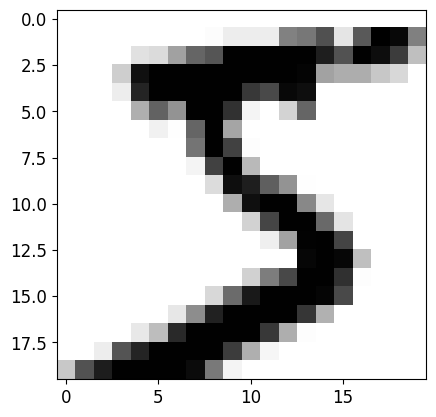

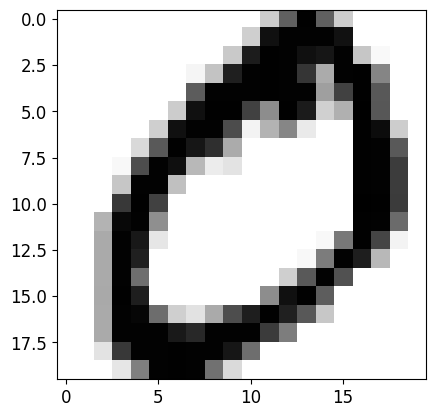

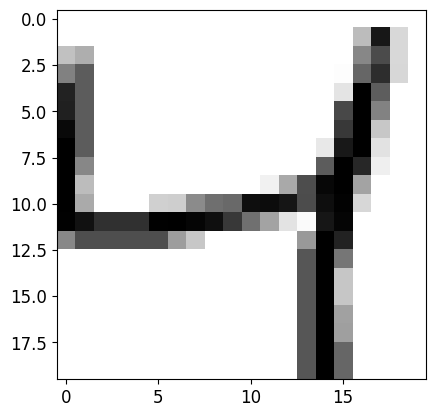

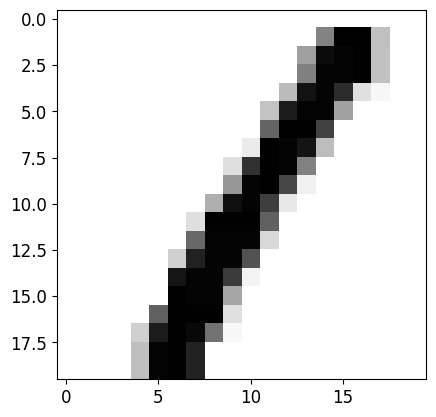

In [31]:
for i in range(4):
  digit = X.iloc[i]
  cropped_digit = crop_image(digit, 4)
  cropped_digit = cropped_digit.reshape(20, 20)
  plt.imshow(cropped_digit, cmap=mpl.cm.binary)
  plt.axis("on")
  plt.show()

In [37]:
import pandas as pd

cropped_images = []

for i in range(len(X)):
  digit = X.iloc[i]
  cropped_digit = crop_image(digit, 4)
  cropped_images.append(cropped_digit)

cropped_images = np.array(cropped_images)
cropped_df = pd.DataFrame(cropped_images)
cropped_df['label'] = y.values


In [40]:
X_cropped = cropped_df.drop('label', axis=1)

X_cropped_train, X_cropped_test = X_cropped[:60000], X_cropped[60000:]


X_cropped_train_scaled = scaler.fit_transform(X_cropped_train.astype(np.float64))
X_cropped_test_scaled = scaler.transform(X_cropped_test.astype(np.float64))

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid for GridSearchCV or RandomizedSearchCV
param_grid = {
  'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
  'max_iter': [1000, 2000, 3000],
  'tol': [1e-3, 1e-4, 1e-5]
}

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_params_'